# Collective compression of 31D jet data

This script loads a .pkl file with 31D jet data (actually >31D, but it then selects a subset of the branches in the loaded fiile) and trains an AE to compress groups of jets into a latent space representation.

The script also contains a number of different visualizations of the data and the compression results. This was used during testing, but neither this training or these visualizations were used for the final thesis report. However, the training operates on the same basic principle as the final training script, and so this script may be easier to follow if one wishes to understand the process.

In [1]:
import os
import uproot
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import corner

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core
from fastai.metrics import mse
from fastai.callback import schedule

import vector

plt.rcParams.update({'font.size': 16, 'lines.markersize' : 10, 'image.cmap' : 'tab20b'})

## Load multi-dimensional ATLAS jet data

In [2]:
# Load multi-dimensional ATLAS jet data

start = time.perf_counter()

path = r'F:\Master\Data\pickles'
data18_filename = r'data18_13TeV_pandas.pkl'

data18 = pd.read_pickle(os.sep.join([path, data18_filename]))

end = time.perf_counter()
print('data read time:', end-start, 'seconds.')

data read time: 1.0936861999999792 seconds.


In [3]:
print(len(data18.columns), 'branches in dataset.\n')
max_len = 0
for column in data18.columns:
    print(column)
    if len(column) > max_len:
        max_len = len(column)

39 branches in dataset.

TrackSumMass
TrackSumPt
ECPSFraction
ActiveArea
ActiveArea4vec_eta
ActiveArea4vec_m
ActiveArea4vec_phi
ActiveArea4vec_pt
AverageLArQF
BchCorrCell
CentroidR
DetectorEta
EMFrac
FracSamplingMax
HECFrac
HECQuality
JetEtaJESScaleMomentum_eta
JetEtaJESScaleMomentum_m
JetEtaJESScaleMomentum_phi
JetEtaJESScaleMomentum_pt
LArQuality
LeadingClusterCenterLambda
LeadingClusterPt
LeadingClusterSecondLambda
LeadingClusterSecondR
N90Constituents
NegativeE
OotFracClusters10
OotFracClusters5
Timing
Width
WidthPhi
Charge
DetectorPhi
GhostTrackPt
JVFCorr
Jvt
JvtRpt
LArBadHVEnergyFrac


In [ ]:
# Calculate the energy of the jets using [pt, eta, phi, m]. It was found during the project that, in the 4D case, jet four-momentum using energy compresses much better than one using mass as the fourth variable.
# The same idea was therefore applied to the multi-dimensional case.

four_branches = ['JetEtaJESScaleMomentum_pt', 'JetEtaJESScaleMomentum_eta', 'JetEtaJESScaleMomentum_phi', 'JetEtaJESScaleMomentum_m']
v = vector.obj(pt=data18[four_branches[0]], eta=data18[four_branches[1]], phi=data18[four_branches[2]], tau=data18[four_branches[3]])
calculated_E = v.E
data18['Calculated_E'] = calculated_E

In [5]:
calculated_E

entry  subentry
0      0           249209.734375
       1            38752.613281
       2            29809.919922
       3           117380.992188
       4            23635.406250
                       ...      
10376  14          176641.656250
       15           16954.771484
       16          263036.187500
       17          334342.562500
       18           17994.369141
Length: 168835, dtype: float32

### List max and min value of all branches, and whether to use response or residual for evaluation

In [8]:
# Based on a given set of criteria, each branch is determined to use either the response (relative error) or residual (absolute error).
# For example, if the variable is zero-centered, the relative error will blow up, so the absolute error is used.

res_type = {}
print('Total # values:', len(data18))
print()
print('{:{max_len}s} {max_value:>16} {min_value:>16} {num_zero:>10} {res:>16}'.format('Branch name', max_len=max_len, max_value='max value', min_value='min value', num_zero='# values=0', res='evaluation type'))
for column in data18.columns:
    cmax = data18[column].max()
    cmin = data18[column].min()
    res_str = 'residual'
    if max(np.abs(cmax), np.abs(cmin)) > 10 and (cmax > 200 or cmin < -200):
        #if sum(data18[column] == 0) / len(data18) < 0.01:
        res_str = 'response'
    res_type[column] = res_str
    print('{:{max_len}s} {max_value:>16.6f} {min_value:>16.6f} {num_zero:>10} {res_str:>16}'.format(column, max_len=max_len, max_value=cmax, min_value=cmin, num_zero=sum(data18[column]==0), res_str=res_str))

Total # values: 168835

Branch name                       max value        min value # values=0  evaluation type
TrackSumMass                  121894.546875      -327.543793      81600         response
TrackSumPt                   9921501.000000         0.000000      81600         response
ECPSFraction                       0.891614         0.000000     162291         residual
ActiveArea                         0.947464         0.019947          0         residual
ActiveArea4vec_eta                 4.851706        -4.870892          0         residual
ActiveArea4vec_m                   0.370560         0.001647          0         residual
ActiveArea4vec_phi                 3.141362        -3.141593          0         residual
ActiveArea4vec_pt                  0.916695         0.019942          0         residual
AverageLArQF                   65535.000000         0.000000       1196         response
BchCorrCell                        0.358346        -0.060075     147246         residu

In [11]:
# Load which branches to use from a text file

b_file = open('branches_E.txt', 'r')
selected_branches = []
for line in b_file.readlines():
    if line[0] != '#':
        selected_branches.append(line.replace('\n', ''))
b_file.close()
print('Number of branches selected:', len(selected_branches), '\n')
for branch in selected_branches:
    print(branch)

Number of branches selected: 31 

JetEtaJESScaleMomentum_pt
JetEtaJESScaleMomentum_eta
JetEtaJESScaleMomentum_phi
Calculated_E
ActiveArea
ActiveArea4vec_pt
ActiveArea4vec_eta
ActiveArea4vec_phi
ActiveArea4vec_m
AverageLArQF
NegativeE
LArQuality
Width
WidthPhi
CentroidR
DetectorEta
LeadingClusterCenterLambda
LeadingClusterPt
LeadingClusterSecondLambda
LeadingClusterSecondR
EMFrac
HECFrac
Timing
OotFracClusters10
OotFracClusters5
ECPSFraction
FracSamplingMax
DetectorPhi
JVFCorr
Jvt
LArBadHVEnergyFrac


In [13]:
units = ['[MeV]',
         '',
         '[rad]',
         '[MeV]',
         '',
         '',
         '',
         '',
         '',
         '',
         '[MeV]',
         '',
         '',
         '',
         '',
         '',
         '',
         '',
         '',
         '',
         '',
         '',
         '[ns]',
         '',
         '',
         '',
         '',
         '[rad]',
         '',
         '',
         '']
branch_units = dict(zip(selected_branches, units))

In [14]:
# Select events
data = data18.copy()

# Filtering
pt_high_cut = 9e5 # Remove a few extreme outliers
pt_low_cut = 20e3 # Jet lower limit pt=20 GeV
eta_cutoff = 2.4 # Constrain to central region of the detector
m_low_cut = 100 # Remove jets with masses close to zero (which are either erroneous or cause the errors to blow up)

mask = np.array([True] * len(data))
masks = {}
mask_variables = ['pt', 'eta', 'm']
masks['pt'] = (data18['JetEtaJESScaleMomentum_pt'] > pt_low_cut) & (data18['JetEtaJESScaleMomentum_pt'] < pt_high_cut)
masks['eta'] = np.abs(data18['JetEtaJESScaleMomentum_eta']) < eta_cutoff
#masks['E'] = mask
masks['m'] = data18['JetEtaJESScaleMomentum_m'] > m_low_cut

for column in data18.columns:
    if res_type[column] == 'response':
        masks[column] = (data18[column] != 0)
        mask_variables.append(column)

print('Jets excluded due to cut in...')
for i, m in enumerate(masks.values()):
    mask = mask & m
    print('{:<30} {}, with total remaining (including previous cuts): {}'.format(mask_variables[i], sum(~m), sum(mask)))

#selected_branches = data18.columns # ['JetEtaJESScaleMomentum_pt', 'JetEtaJESScaleMomentum_eta', 'JetEtaJESScaleMomentum_phi', 'Calculated_E']
data18_masked = data18[mask]
data = data18_masked[selected_branches]

branches = data.columns

from satools.satools import normalize

scheme = 'div_by_range'
norm_data, norm_params = normalize(data, scheme=scheme)

dataset_name = 'ROOT file: data18_13TeV.00360026.physics_Main.merge.AOD.f969_m2020._lb0151._0006.1, selected branches'
print('Total number of jets:', len(data18))
print('Number of jets after exclusions:', len(data))

Jets excluded due to cut in...
pt                             87274, with total remaining: 81561
eta                            53669, with total remaining: 58660
m                              13670, with total remaining: 58656
TrackSumMass                   81600, with total remaining: 47450
TrackSumPt                     81600, with total remaining: 47450
AverageLArQF                   1196, with total remaining: 47424
CentroidR                      0, with total remaining: 47424
JetEtaJESScaleMomentum_m       5237, with total remaining: 47424
JetEtaJESScaleMomentum_pt      0, with total remaining: 47424
LeadingClusterCenterLambda     36, with total remaining: 47404
LeadingClusterPt               0, with total remaining: 47404
LeadingClusterSecondLambda     7, with total remaining: 47402
LeadingClusterSecondR          7, with total remaining: 47402
NegativeE                      1093, with total remaining: 47402
Charge                         44274, with total remaining: 47402
Ghost

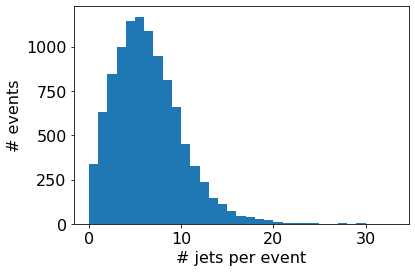

In [15]:
main_idxs = np.array([idx[0] for idx in norm_data.index])
sub_idxs = np.array([idx[1] for idx in norm_data.index])
max_idx = max(main_idxs)

jets_per_main_idx = []
for i in range(max_idx):
    if not sub_idxs[main_idxs == i].shape[0] == 0:
        jets_per_main_idx.append(max(sub_idxs[main_idxs == i]))

_ = plt.hist(jets_per_main_idx, bins=max(jets_per_main_idx))
plt.ylabel('# events');
plt.xlabel('# jets per event');

## Visualize the data

Viewing the ROOT file: data18_13TeV.00360026.physics_Main.merge.AOD.f969_m2020._lb0151._0006.1, selected branches


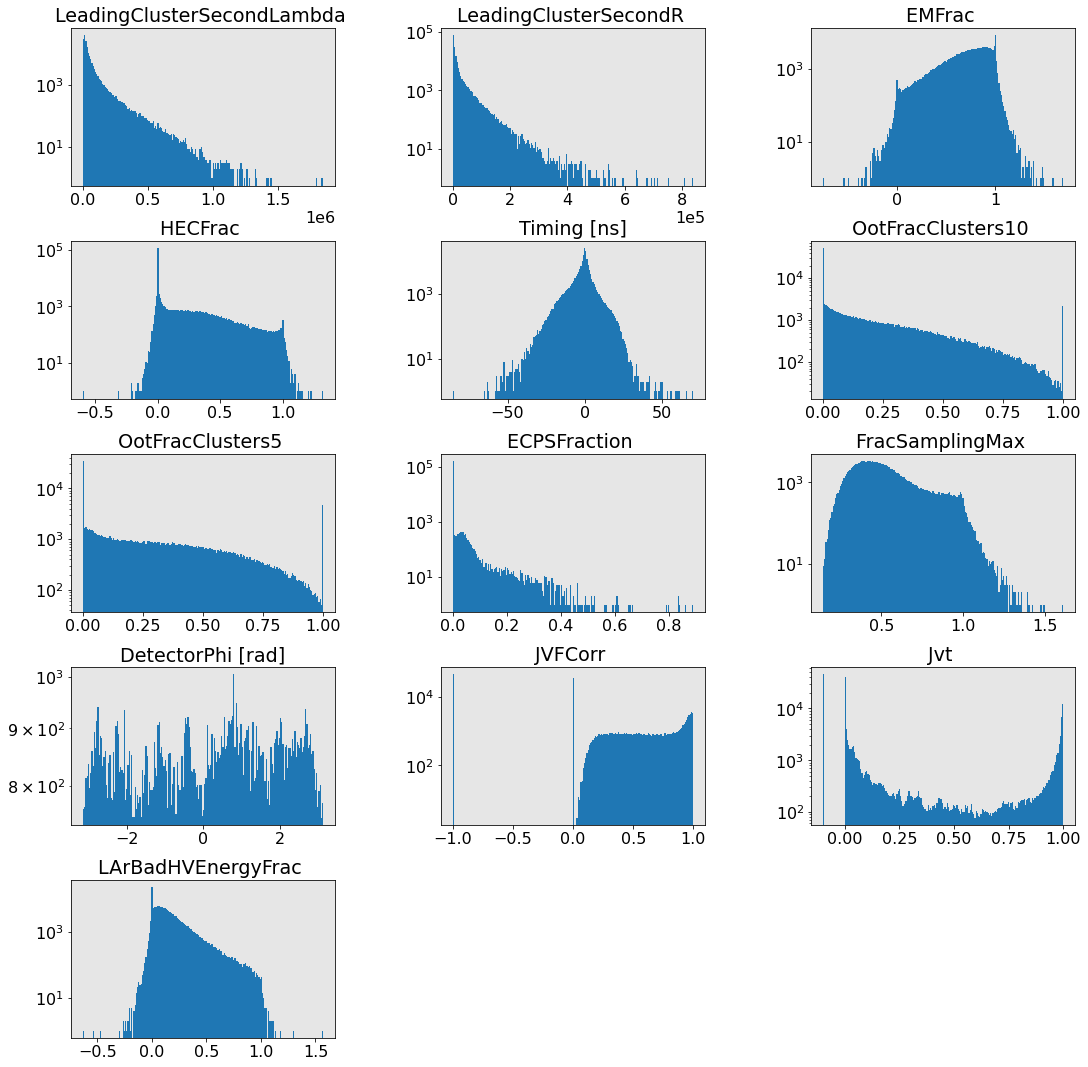

In [19]:
n_bins = 200

print('Viewing the ' + dataset_name)
    
selected_branches = branches[18:]
fig = plt.figure(figsize=(18, 1.5*15))
for i, branch in enumerate(selected_branches):
    plt.subplot(6, 3, i+1)
    _ = plt.hist(data18[branch], bins=n_bins)
    plt.yscale('log')
    xlims = plt.xlim()
    if xlims[0] < -10000 or xlims[1] > 10000:
        plt.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    plt.title(branch + ' ' + branch_units[branch])
    plt.gca().set_facecolor((0.9, 0.9, 0.9))
    
plt.subplots_adjust(hspace=0.35, wspace=0.4)

Viewing the ROOT file: data18_13TeV.00360026.physics_Main.merge.AOD.f969_m2020._lb0151._0006.1, selected branches
Number of jets: 47402


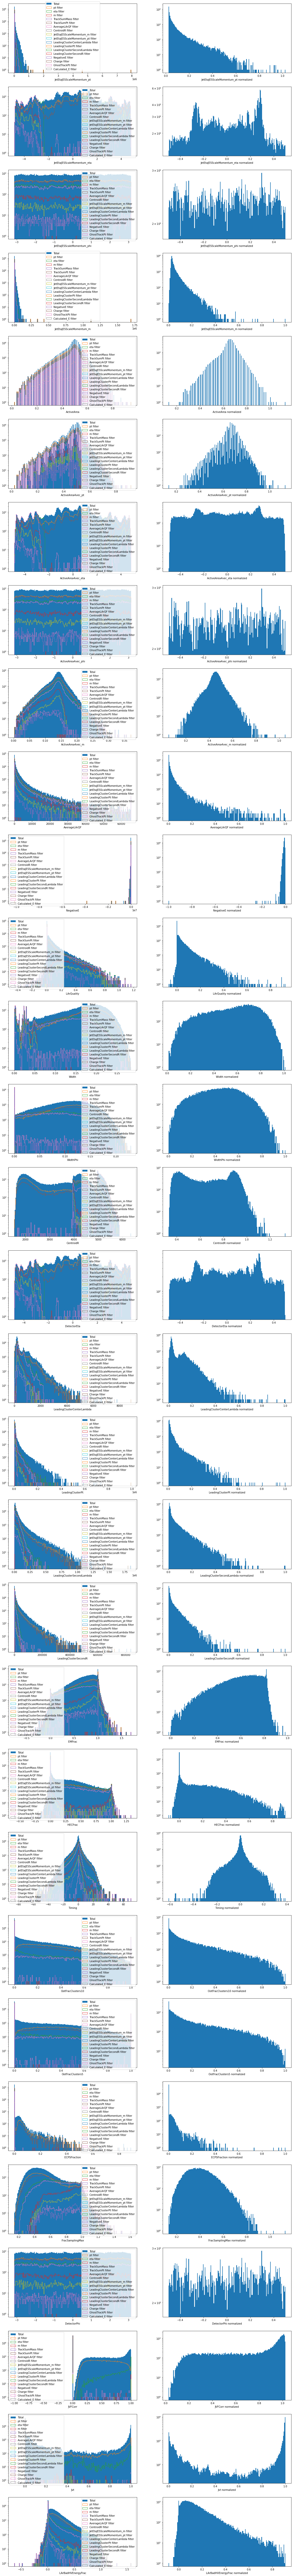

In [12]:
# Show where the jets that get cut are located in the distributions of each variable

n_bins = 200

print('Viewing the ' + dataset_name)
    
fig = plt.figure(figsize=(20, 6*len(branches)))
for i, branch in enumerate(branches):
    plt.subplot(len(branches), 2, 2*i+1)
    bins = np.linspace(min(data18[branch]), max(data18[branch]), n_bins)
    _ = plt.hist(data18[branch], bins=bins, label='Total', density=False)
    for j, m in enumerate(masks.values()):
        _ = plt.hist(data18[branch][~m], bins=bins, label=mask_variables[j] + ' filter', density=False, histtype='step', linewidth=1)
    ax = plt.gca()
    ax.set_xlabel(branch)
    plt.yscale('log')
    plt.legend()
    
    plt.subplot(len(branches), 2, 2*i+2)
    _ = plt.hist(norm_data[branch], bins=n_bins)
    plt.xlabel(branch + ' normalized')
    plt.yscale('log')

n_jets = len(data)
    
print('Number of jets:', n_jets)

In [20]:
# AE model

class Model(nn.Module):
    def __init__(self, n_features=4, group_size=2, latent_space_size=7):
        super(Model, self).__init__()      
        
        self.n_features = n_features
        self.group_size = group_size
        self.latent_space_size = latent_space_size
        
        self.en1 = nn.Linear(group_size*n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 200)
        self.en4 = nn.Linear(200, latent_space_size)
        self.de1 = nn.Linear(latent_space_size, 200)
        self.de2 = nn.Linear(200, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, group_size*n_features)
        self.act = nn.Tanh()
    
    def encode(self, x):
        return self.en4(self.act(self.en3(self.act(self.en2(self.act(self.en1(x)))))))
    
    def decode(self, x):
        return self.de4(self.act(self.de3(self.act(self.de2(self.act(self.de1(self.act(x))))))))
    
    def forward(self, x, mode = 'both'):
        assert mode in ['both', 'encode', 'decode'], 'model expects keyword mode to be \'encode\', \'decode\' or \'both\'.'
        if mode == 'encode':
            return self.encode(x)
        elif mode == 'decode':
            return self.decode(x)
        else:
            z = self.encode(x)
            return self.decode(z)
    
    def describe(self):
        description = ''
        for module in [self.en1, self.en2, self.en3, self.en4, self.de1, self.de2, self.de3, self.de4]:
            description += str(module.in_features) + '-'
        description += str(module.out_features) + ', activation function: ' + str(self.act)
        return description

### Define network features and instantiate model

In [12]:
n_features = data.shape[1] # i.e. input dimensionality
group_size = 2 # number of jets to group before compression
latent_space_size = 25 * group_size
if not latent_space_size < group_size*n_features:
    print('WARNING! Dimensionality of latent space is not lower than that of input data!')

print('Number of features:', n_features)
print('Latent space size:', latent_space_size)
model = Model(n_features=n_features, group_size=group_size, latent_space_size=latent_space_size)
model.to('cpu')
print(model.describe())

Number of features: 32
Latent space size: 50
64-200-200-200-50-200-200-200-64, activation function: Tanh()


# Organize dataset depending on sorting and grouping properties

In [55]:
props = ['same_event', 'random', 'pt_sort']
prop = props[0]

# Make sure that there are a number of jets included from each event evenly divisible by group_size
if prop == 'same_event':
    check_idxs =  True
    while check_idxs:
        full_mask = np.array([True] * len(norm_data))

        main_idxs = np.array([idx[0] for idx in norm_data.index])
        sub_idxs = np.array([idx[1] for idx in norm_data.index])

        sub_cuts = sub_idxs.copy()
        sub_cuts[:-1] = sub_cuts[:-1] - sub_cuts[1:]
        sub_max = np.where(sub_cuts >= 0)[0]
        jets_per_event = sub_max.copy()
        jets_per_event[1:] = jets_per_event[1:] - jets_per_event[:-1]
        jets_per_event[0] += 1

        mask = np.array(jets_per_event % group_size != 0)
        full_mask[sub_max[mask]] = False
        norm_data = norm_data[full_mask]

        if sum(mask) == 0:
            check_idxs = False

# Load a custom randomized order
if prop == 'random':
    random_order = pd.read_pickle('random_jet_order.txt')
    norm_data = norm_data.iloc[random_order]

In [56]:
# Split dataset into training and testing data

from satools.satools import group

split_idx = int(3/4 * norm_data.shape[0])

# Make sure the split is made so that training and testing datasets include entire events
if prop == 'same_event':
    while norm_data.index[split_idx-1][0] == norm_data.index[split_idx][0]:
        split_idx += 1
    training_idxs = (0, split_idx)
    testing_idxs = (split_idx, norm_data.shape[0])
else:
    training_idxs = (0, split_idx)
    testing_idxs = (split_idx, norm_data.shape[0])

training_data = norm_data[training_idxs[0] : training_idxs[1]]
if prop == 'pt_sort':
    training_data = training_data.sort_values(by='JetEtaJESScaleMomentum_pt')
training_data = torch.tensor(training_data.values)
training_data = group(training_data, group_size=group_size)
training_target = training_data

testing_data = norm_data[testing_idxs[0] : testing_idxs[1]]
if prop == 'pt_sort':
    testing_data = testing_data.sort_values(by='JetEtaJESScaleMomentum_pt')
testing_data = torch.tensor(testing_data.values)
testing_data = group(testing_data, group_size=group_size)
testing_target = testing_data

In [57]:
loss_function = nn.MSELoss()
batch_size = 256
weight_decay = 1e-6
shuffle = True

training_ds = TensorDataset(training_data, training_target)
testing_ds = TensorDataset(testing_data, testing_target)

training_dl = DataLoader(training_ds, batch_size=batch_size, shuffle=shuffle)
testing_dl = DataLoader(testing_ds, batch_size=batch_size)
dataloaders = core.DataLoaders(training_dl, testing_dl)

recorder = learner.Recorder()
learn = learner.Learner(dataloaders, model=model, wd=weight_decay, loss_func=loss_function, cbs=recorder)

# Load a pre-trained model

In [58]:
load = False
if load:
    load_filename = 'AE200-68-50-div_by_range-branches1-prop-same_event'
    learn.load(load_filename)
    print('Loaded model', load_filename, '\nValidation loss of loaded model:')
    print(learn.validate())

# OR train a new model

Learning rate with the minimum loss: 0.0009120108559727668
Learning rate with the steepest gradient: 0.0008317637839354575


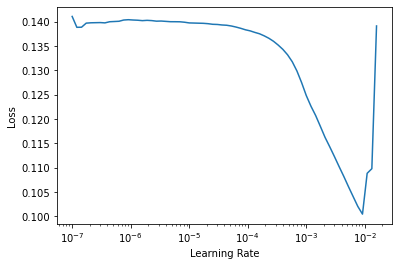

In [59]:
lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

In [275]:
# Training run

n_epochs = 2000
lr = lr_min
print('Learning rate:', lr)

t = time.perf_counter()
learn.fit_one_cycle(n_epoch=n_epochs, lr_max=lr)
print('Total training time:', time.perf_counter() - t, 'seconds.')

Learning rate: 0.0015848932787775993
[0, 0.03725956380367279, 0.029012247920036316, '00:01']
[0, 0.03725956380367279, 0.029012247920036316, '00:01']
[1, 0.02206753008067608, 0.017445752397179604, '00:01']
[1, 0.02206753008067608, 0.017445752397179604, '00:01']
[2, 0.00951151829212904, 0.007503484841436148, '00:01']
[2, 0.00951151829212904, 0.007503484841436148, '00:01']
[3, 0.007208334747701883, 0.006721050012856722, '00:01']
[3, 0.007208334747701883, 0.006721050012856722, '00:01']
[4, 0.005860276985913515, 0.0052003939636051655, '00:01']
[4, 0.005860276985913515, 0.0052003939636051655, '00:01']
[5, 0.0037739411927759647, 0.0031953586731106043, '00:01']
[5, 0.0037739411927759647, 0.0031953586731106043, '00:01']
[6, 0.003033558838069439, 0.002858089981600642, '00:01']
[6, 0.003033558838069439, 0.002858089981600642, '00:01']
[7, 0.0026774336583912373, 0.0025984279345721006, '00:01']
[7, 0.0026774336583912373, 0.0025984279345721006, '00:01']
[8, 0.002504096133634448, 0.0024244971573352814

Loss as a function of batches trained:


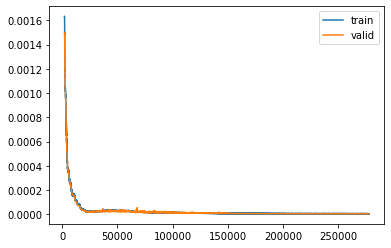


Learning rate and momentum as functions of batches trained:


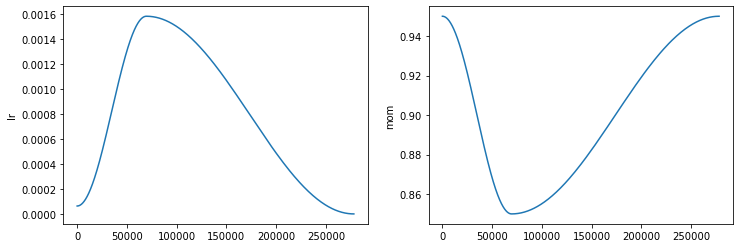

In [276]:
print('Loss as a function of batches trained:')
recorder.plot_loss(skip_start = 2000)
plt.show()
print()
print('Learning rate and momentum as functions of batches trained:')
recorder.plot_sched()
plt.show()

In [277]:
# Option to save the model

save_model_name = 'AE200-34-25-div_by_range-branches1-no-E'
learn.save(save_model_name)

Path('models/AE200-34-25-div_by_range-branches1-no-E.pth')

In [279]:
# Option to save the losses recorded during training

losses, iters, values = recorder.losses, recorder.iters, recorder.values
pd.to_pickle((losses, iters, values), r'F:\Master\Data\storage\multi-dim-AE\AE200-34-25-div_by_range-branches1-no-E')

Viewing ROOT file: data18_13TeV.00360026.physics_Main.merge.AOD.f969_m2020._lb0151._0006.1, selected branches
# jets in this test set: 10592
# features: 34 
Group size: 2 
Latent space size: 50
68-200-200-200-50-200-200-200-68, activation function: Tanh()


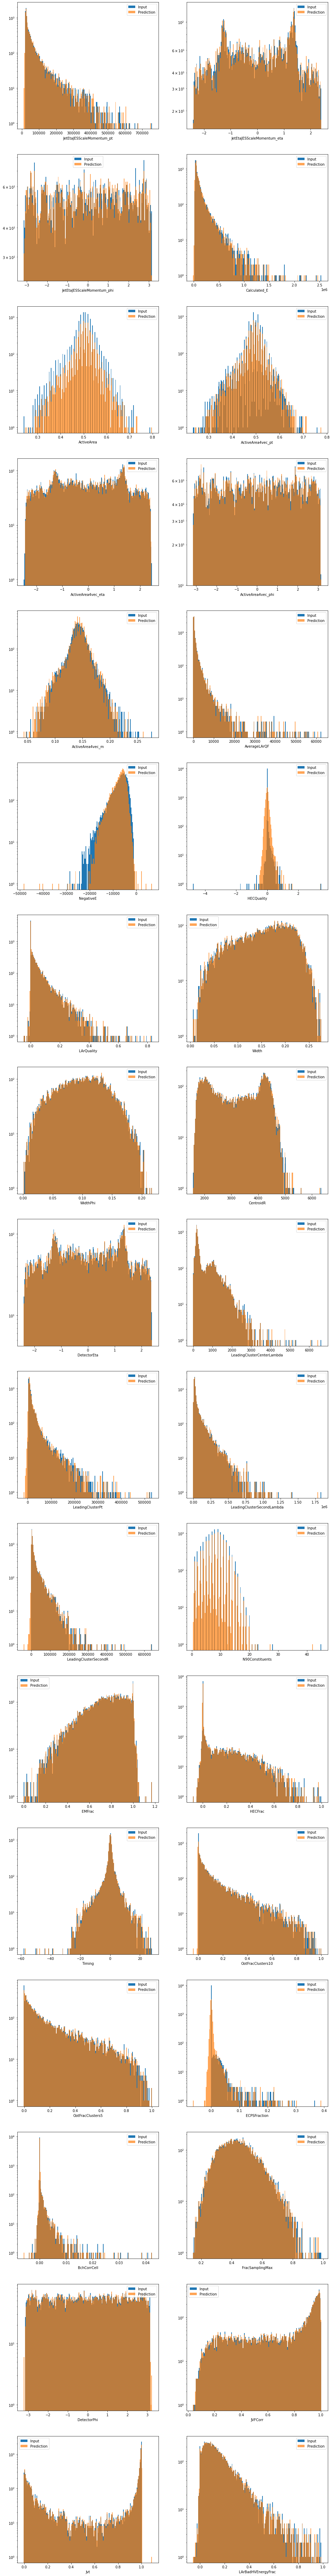

In [27]:
# Visualize input and output distributions

from satools.satools import ungroup, unnormalize

orig = ungroup(testing_data, group_size=group_size).detach().numpy()
pred = ungroup(model(testing_data), group_size).detach().numpy()

orig = pd.DataFrame(orig)
orig.columns = branches
pred = pd.DataFrame(pred)
pred.columns = branches

orig = unnormalize(orig, norm_params, scheme=scheme)
pred = unnormalize(pred, norm_params, scheme=scheme)

n_bins = 200
fig = plt.figure(figsize=(16, 8*len(branches)))
for i, branch in enumerate(branches):
    plt.subplot(len(branches), 2, i+1)
    limits = (min(min(orig[branch]), min(pred[branch])), max(max(orig[branch]), max(pred[branch])))
    bins = np.linspace(limits[0], limits[1], n_bins)
    _ = plt.hist(orig[branch], bins=bins, density=False)
    _ = plt.hist(pred[branch], bins=bins, density=False, alpha=0.7)
    plt.legend(['Input', 'Prediction'])
    plt.xlabel(branch)
    plt.yscale('log')

print('Viewing', dataset_name)
print('# jets in this test set:', len(orig))
print('# features:', n_features, '\nGroup size:', group_size, '\nLatent space size:', latent_space_size)
print(model.describe())

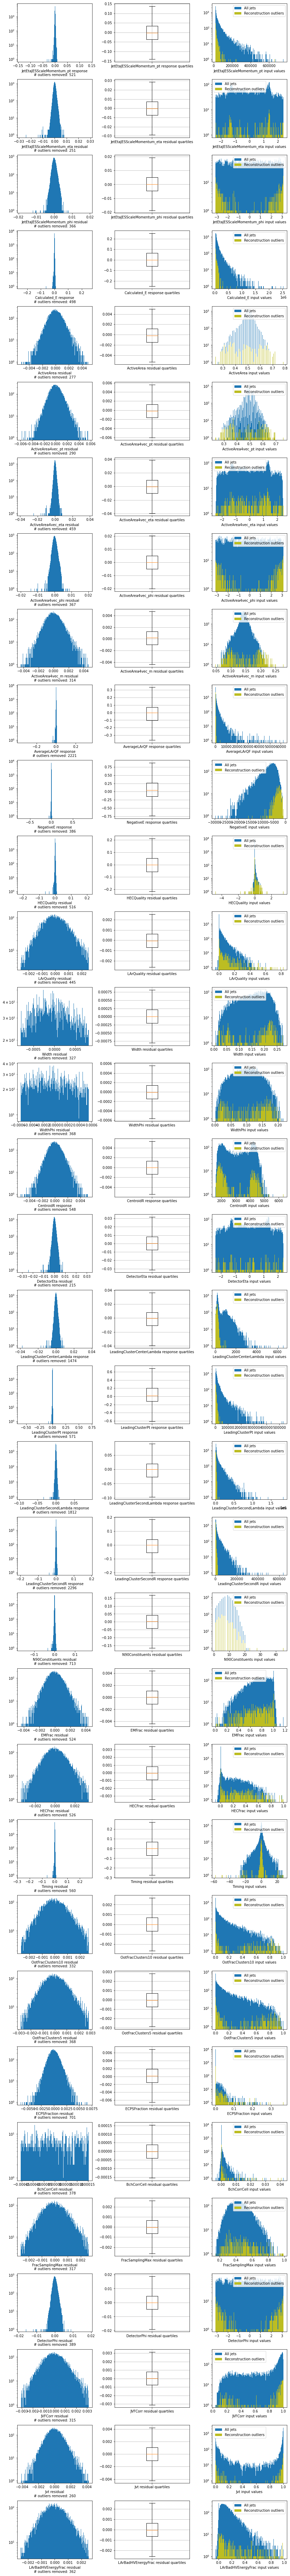

In [28]:
# Calculate responses and residuals

res = pred - orig
for column in res.columns:
    if res_type[column] == 'response':
        res[column] = res[column] / orig[column]

n_bins = 200

#ranges = [(min(res[branch]), max(res[branch])) for branch in branches]
#limits = [np.linspace(a, b, n_bins) for (a, b) in ranges]
#limits = [np.linspace(a, b, n_bins) for (a, b) in [(-0.05, 0.05), (-0.05, 0.05), (-0.04, 0.04), (-0.02, 0.02), (-0.03, 0.03), (-0.03, 0.03)]]

bin_edges = {}
bin_counts = {}
bin_max_ixs = {}

fig = plt.figure(figsize=(14, 4*len(branches)))
for i, branch in enumerate(branches):
    # Box plot
    plt.subplot(len(branches), 3, 3*i+2)
    box = plt.boxplot(res[branch], sym='', labels=[branch + ' ' + res_type[branch] + ' quartiles'])
    plt.grid()
    
    low_cut = box['caps'][0].get_ydata()[0]
    high_cut = box['caps'][1].get_ydata()[0]
    mask = (res[branch] < high_cut) & (res[branch] > low_cut)
    
    limits = np.linspace(min(res[branch][mask]), max(res[branch][mask]), n_bins)
    
    # Res plot
    plt.subplot(len(branches), 3, 3*i+1)
    bin_counts[branch], bin_edges[branch], _ = plt.hist(res[branch][mask], bins=limits, density=False)
    bin_max_ixs[branch] = np.where(bin_counts[branch] == bin_counts[branch].max())  

    plt.xlabel(branch + ' ' + res_type[branch] + '\n# outliers removed: ' + str(sum(~mask)))
    plt.yscale('log')

    # Original distribution
    plt.subplot(len(branches), 3, 3*i+3)
    counts, edges, _ = plt.hist(orig[branch], bins=n_bins, label='All jets')
    plt.hist(orig[branch][~mask], bins=edges, label='Reconstruction outliers', color='tab:olive')
    plt.xlabel(branch + ' input values')
    plt.legend()
    plt.yscale('log')
    
    #print(branch + ' ' + res_type[branch] + ' mean:', res[branch].mean())
    #print(branch + ' ' + res_type[branch] + ' std:', res[branch].std())
    #print()
    
plt.subplots_adjust(wspace=0.3, hspace=0.3)

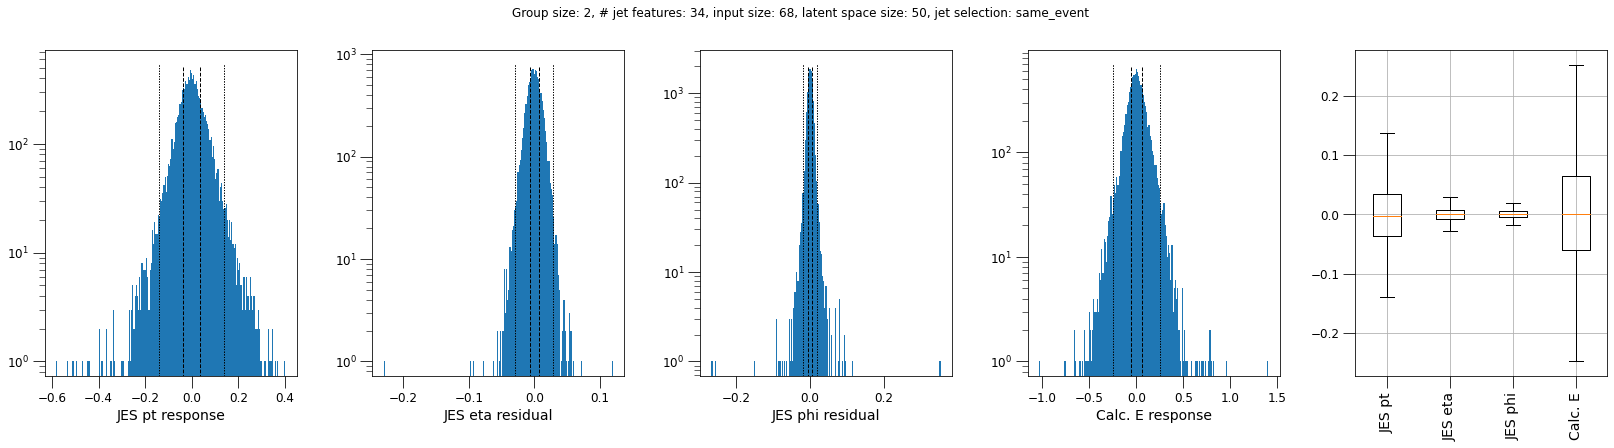

In [46]:
# View results for only the four-momentum variables

reduced_branches = ['JetEtaJESScaleMomentum_pt', 'JetEtaJESScaleMomentum_eta', 'JetEtaJESScaleMomentum_phi', 'Calculated_E']
short_four_branches = ['JES pt', 'JES eta', 'JES phi', 'Calc. E']
short_reduced_branches = {reduced_branches[i] : short_four_branches[i] for i in range(len(reduced_branches))}
n_bins = 200
include = 0.995

fig = plt.figure(figsize=(28, 6))
ax2 = fig.add_subplot(1, 5, 5)
box = plt.boxplot(res[reduced_branches], sym='', labels=short_reduced_branches.values())
plt.grid()

for i, branch in enumerate(reduced_branches):
    ax1 = fig.add_subplot(1, 5, i+1)
    mask = np.abs(res[branch]) < include * np.abs(res[branch]).max()
    limits = np.linspace(min(res[branch][mask]), max(res[branch][mask]), n_bins)
    counts, edges, _ = plt.hist(res[branch][mask], bins=limits, density=False)
    plt.vlines(box['boxes'][i].get_ydata()[[0, 2]], ymax=ax1.get_ylim()[0], ymin=ax1.get_ylim()[1], linestyles='dashed', color='k', linewidth=1)
    plt.vlines([box['caps'][2*i].get_ydata(), box['caps'][2*i+1].get_ydata()], ymax=ax1.get_ylim()[0], ymin=ax1.get_ylim()[1], linestyles='dotted', color='k', linewidth=1)
    plt.xlabel(short_reduced_branches[branch] + ' ' + res_type[branch])
    plt.yscale('log')
    ax1.set_xlabel(ax1.get_xlabel(), fontsize=14)
    ax1.set_ylabel(ax1.get_ylabel(), fontsize=12)
    ax1.tick_params(axis='both', which='minor', size=6, labelsize=12)
    ax1.tick_params(axis='both', which='major', size=12, labelsize=12)
    #ax1.legend(fontsize=12)

ax2.set_ylabel(ax2.get_ylabel(), fontsize=12)
ax2.tick_params(axis='both', which='minor', size=6, labelsize=12)
ax2.tick_params(axis='y', which='major', size=12, labelsize=12)
ax2.tick_params(axis='x', which='major', size=12, labelsize=14)
ax2.tick_params(axis='x', rotation=90)
#ax2.set_yticks(np.arange(-.1, .11, .05))
#ax2.set_yticks(np.arange(-.1, .11, .025), minor=True)
ax2.grid(which='minor', linestyle=':')
#ax2.legend(fontsize=12)

title_str = 'Group size: ' + str(group_size) + ', # jet features: ' + str(n_features) + ', input size: ' + str(group_size*n_features) + ', latent space size: ' + str(latent_space_size) + ', jet selection: ' + prop
fig.suptitle(title_str);
plt.subplots_adjust(wspace=0.3)